In [60]:
import pandas as pd

Index(['repeat_i', 'is_change_apply_to_test', 'classifier_name',
       'dataset_name', 'semantic_change', 'char_freq_range', 'test_acc',
       'test_f1', 'train_loss', 'test_loss', 'train_size', 'val_size',
       'test_size'],
      dtype='object')


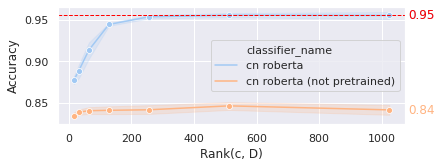

In [178]:
import pdb
import seaborn as sns
import matplotlib.pyplot as plt

# plot the trend when we changing only char freq

origin_df = pd.read_csv('../result/cn_novel_5billion_cn_roberta_None.csv')
pretrain_acc = origin_df[origin_df['char_freq_range'] == 0]['test_acc'].mean()
origin_df_non_pretrain = pd.read_csv('../result/cn_novel_5billion_cn_roberta_no_pretrain_None.csv')
origin_df = pd.concat([origin_df, origin_df_non_pretrain])

origin_df = origin_df[origin_df['char_freq_range'] != 0]
print(origin_df.keys())
# print(origin_df)
sns.set(rc={'figure.figsize':(6.4, 2.5)})


plot_df = {'char_freq_range': [], 'value': [], 'type': [], 'classifier_name': []}
for char_freq_range, char_freq_df in origin_df.groupby('char_freq_range'):
    plot_df['classifier_name'].extend(char_freq_df['classifier_name'].values)
    plot_df['value'].extend(char_freq_df['test_acc'].values)
    plot_df['type'].extend(['acc' for _ in char_freq_df['test_acc'].values])
    plot_df['char_freq_range'].extend([char_freq_range for _ in char_freq_df['test_acc'].values])

plot_df = pd.DataFrame(plot_df)


def tmp_func(x):
    if x == 'cn_roberta':
        return 'cn roberta'
    elif x == 'cn_roberta_no_pretrain':
        return 'cn roberta (not pretrained)'

plot_df['classifier_name'] = plot_df['classifier_name'].apply(tmp_func)


# ci = confidence interval
ax = sns.lineplot(data=plot_df, x="char_freq_range", y="value", marker="o", hue='classifier_name', palette = "pastel")
ax.axhline(pretrain_acc, ls='--', color='red', linewidth=1)
# ax.set_title("How eliminating chars based on frequency rank affects performance")
ax.set(xlabel='Rank(c, D)', ylabel='Accuracy')

annotate_lines = ax.lines
for l in annotate_lines:
    y = l.get_ydata()
    if len(y)>0:
        ax.annotate(f'{y[-1]:.2f}', xy=(1.01,y[-1]), xycoords=('axes fraction', 'data'), 
                     ha='left', va='center', color=l.get_color())
plt.tight_layout()
plt.savefig('exp_semantic_change_with_char_freq1.pdf')
plt.show()

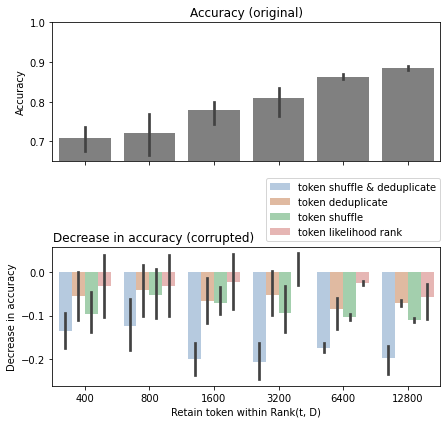

In [12]:
import os
import glob
import pdb
import copy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


dataset_name = 'en_grover' # cn_novel_5billion, en_grover, en_writing_prompt
classifier_name = 'en_roberta' # cn_roberta, en_roberta

all_files = glob.glob(os.path.join('/home/iamlxb3/temp_rsync_dir/story_turing_test/result/', '*.csv'))
all_df = pd.concat([pd.read_csv(x) for x in all_files])
all_df = all_df[all_df['dataset_name']==dataset_name]
all_df = all_df[all_df['classifier_name']==classifier_name]

is_change_apply_to_test = True
# print(all_df['is_change_apply_to_test'])

# sns.set(rc={'figure.figsize':(6.4, 4),'axes.grid' : False})

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6.4, 6), sharex=True)


all_df = all_df[all_df['is_change_apply_to_test'] == is_change_apply_to_test]
all_df = all_df[~all_df['semantic_change'].isin({'rm_chars_out_freq',
                                                 'rm_chars_in_freq',
                                                 "['reorder_freq_low2high']",
                                                 "['reorder_freq_high2low']",
                                                 "['dep']",
                                                 "['ner']",
                                                 "['pos']",
                                                 "['constit']",
                                                 "['not_use_stopword']",
                                                 "['use_stopword']"
                                                })]

# print(other_df['semantic_change'].values)

pretrain_df = copy.deepcopy(all_df)
pretrain_plot_df = {'char_freq_range': [], 
           'acc':[], 
           'origin_acc': [], 
           'relative_improve': [], 
           'type': [], 
           'semantic_change': []}

def rename_semantic_change(x):
    dict1 = {
             "['None']": 'origin',
             "['reorder_shuffle']": 'token shuffle',
             "['char_deduplicate']": 'token deduplicate',
             "['reorder_freq_low2high']": 'sort descend (Global character frequency)',
             "['reorder_freq_high2low']": 'sort ascend (Global character frequency)',
             "['reorder_shuffle', 'char_deduplicate']": 'token shuffle & deduplicate',
             "['likelihood_rank']":'token likelihood rank',
             "['use_stopword']":'include only stopwords',
             "['not_use_stopword']":'exclude stopwords'
    }
    return dict1[x]

pretrain_df['semantic_change'] = pretrain_df['semantic_change'].apply(rename_semantic_change)

def create_plot_df(src_df, target_df):
    for char_freq_range, char_freq_df in src_df.groupby('char_freq_range'):

        if char_freq_range == 0:
            continue

        origin_mask = char_freq_df['semantic_change'] == "origin"
        origin_df = char_freq_df[origin_mask]
        other_df = char_freq_df[~origin_mask]
        
        for i, row in other_df.iterrows():
            test_acc = row['test_acc']
            semantic_change = row['semantic_change']
            repeat_i = row['repeat_i']
            origin_row_df = origin_df[origin_df['repeat_i'] == repeat_i]
            
            try:
                origin_acc = float(origin_row_df['test_acc'])
            except:
                pdb.set_trace()

            relative_improve = test_acc - origin_acc

            target_df['char_freq_range'].append(char_freq_range)
            target_df['acc'].append(test_acc)
            target_df['origin_acc'].append(origin_acc)
            target_df['relative_improve'].append(relative_improve)
            target_df['type'].append('acc')
            target_df['semantic_change'].append(semantic_change)
    target_df = pd.DataFrame(target_df)
    return target_df

pretrain_plot_df = create_plot_df(pretrain_df, pretrain_plot_df)

origin_df = pretrain_df[pretrain_df['semantic_change'] == "origin"]
origin_df = origin_df[origin_df['char_freq_range']!=0]

ax1 = sns.barplot(data=origin_df, x="char_freq_range", y="test_acc", ax=ax1, color='#808080', saturation=.5)

if dataset_name == 'en_grover':
    ax1.set(ylim=(0.65, 1.0))
elif dataset_name == 'en_writing_prompt':
    ax1.set(ylim=(0.9, 1.0))
    
ax1.set_title('Accuracy (original)')
ax1.set(ylabel='Accuracy')
ax2 = sns.barplot(data=pretrain_plot_df, x="char_freq_range", y="relative_improve", hue="semantic_change", palette = "pastel", saturation=.5, ax=ax2)
# ax1.get_legend().remove()
ax2.set_title("Decrease in accuracy (corrupted)", x=0.26)
# ax1.set(xticklabels=[])
ax1.set(xlabel=None)
ax2.set(xlabel='Retain token within Rank(t, D)')
ax2.set(ylabel='Decrease in accuracy')
# fig.text(-0.05, 0.5, 'Relative decrease of accuracy', va='center', rotation='vertical')
# ax1.set(xlabel='Rank(c, D)', ylabel='Relative decrease of accuracy')

# ax2 = sns.barplot(data=no_pretrain_plot_df, x="char_freq_range", y="relative_improve", hue="semantic_change", palette = "pastel", saturation=.5, ax=ax2)
# ax2.set_title("Non-pretrained Roberta", x=0.185)
# # ax2.set(xlabel='Rank(c, D)', ylabel='Relative decrease of accuracy')
# ax2.set(xlabel='Rank(c, D)')
# ax2.set(ylabel=None)
# 

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
# change_width(ax, .12)

#ax.set_title("How semantic change of text affects accuracy")
plt.legend(bbox_to_anchor=(1.0, 1.04), loc=4, borderaxespad=0.0)
plt.tight_layout()
plt.savefig(f'/home/iamlxb3/temp_rsync_dir/story_turing_test/vis/char_freq_range_{dataset_name}.pdf')
plt.show()